**Recycling robot example** (from Sutton, page 42)
References:
  - Gym documentation: https://gym.openai.com/

  

In [2]:
from gym.envs.toy_text import discrete
import random
import matplotlib.pyplot as plt
from itertools import cycle
import numpy as np

In [3]:
# because of gym.spaces warnings
import warnings
warnings.filterwarnings('ignore')

# Considere el modelo del robot de reciclaje descríto en Sutton Example 3.2

<img src="img/example3.2-1.png" width="500" align="left">

<img src="img/example3.2-2.png" width="500" align="left">

In [4]:
states  = ["high", "low"]
actions = ["wait", "search", "recharge"]

P = {}

P[0] = {}
P[1] = {}

alpha = 0.9
beta = 0.9
r_wait = 2
r_search = 3

# definimos un ambiente discreto con las transiciones según el gráfico
def generar_ambiente(alpha=alpha, beta=beta, r_wait=r_wait, r_search=r_search):
    P[0][0] = [(1.0, 0, r_wait, False)]
    P[0][1] = [(alpha, 0, r_search, False),
               (1-alpha, 1, r_search, False)]
    P[0][2] = [(1,0,0,False)]

    P[1][0] = [(1.0, 1, r_wait, False)]
    P[1][1] = [(beta, 1, r_search, False), 
               (1-beta, 0, -3.0, False)]
    P[1][2] = [(1.0, 0, 0.0, False)]
    env = discrete.DiscreteEnv(2, 3, P, [0.0, 1.0])
    return(env)
env = generar_ambiente()

# Implemente la estrategia random para veinte episodios. 


Definir una acción aleatoria y ver que reward produce

In [5]:
def randomExperiment(env):
    time_steps=20
    verbose=True
    history = np.empty((time_steps, 3))
    rewardAcum = 0
    state=env.s # < starting state
    print("Starting at state: ", state)
    print("Obs\tDone\tReward\tC.Reward\tAction")
    for i in range(time_steps):
        # when on state 0 (high), action 2 (recharge) is not an option:
        actions = [0,1,2][:2+state]
        # choose a random action
        action = np.random.choice(actions)
        # take that action
        state, reward, done, info = env.step(action)
        rewardAcum += reward
        # data to return
        history[i] = np.array([i+1, reward, rewardAcum])
        if verbose:
            print(state,"\t", done,"\t", reward, "\t", "%.4f" % rewardAcum, "\t", action)
        env.close()
    return history

In [6]:
env.reset()
env = generar_ambiente(alpha=0.9, beta=0.6, r_wait=0.5, r_search=1)
data = randomExperiment(env)

Starting at state:  1
Obs	Done	Reward	C.Reward	Action
0 	 False 	 -3.0 	 -3.0000 	 1
0 	 False 	 0.5 	 -2.5000 	 0
0 	 False 	 1 	 -1.5000 	 1
0 	 False 	 1 	 -0.5000 	 1
0 	 False 	 0.5 	 0.0000 	 0
0 	 False 	 1 	 1.0000 	 1
0 	 False 	 0.5 	 1.5000 	 0
0 	 False 	 0.5 	 2.0000 	 0
0 	 False 	 1 	 3.0000 	 1
0 	 False 	 0.5 	 3.5000 	 0
1 	 False 	 1 	 4.5000 	 1
0 	 False 	 -3.0 	 1.5000 	 1
0 	 False 	 1 	 2.5000 	 1
0 	 False 	 1 	 3.5000 	 1
0 	 False 	 0.5 	 4.0000 	 0
0 	 False 	 0.5 	 4.5000 	 0
0 	 False 	 1 	 5.5000 	 1
0 	 False 	 1 	 6.5000 	 1
0 	 False 	 1 	 7.5000 	 1
0 	 False 	 1 	 8.5000 	 1


# Grafique la recompensa acumulada

In [7]:
# history data to numpy,
#data = np.array(data)
data[0:6]

array([[ 1. , -3. , -3. ],
       [ 2. ,  0.5, -2.5],
       [ 3. ,  1. , -1.5],
       [ 4. ,  1. , -0.5],
       [ 5. ,  0.5,  0. ],
       [ 6. ,  1. ,  1. ]])

In [8]:
# so I can do this
data[0:6, 1]

array([-3. ,  0.5,  1. ,  1. ,  0.5,  1. ])

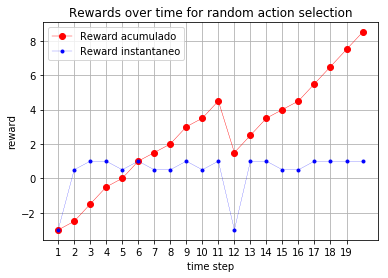

In [9]:
def plotRewardFromData(data):
    plt.grid()
    plt.title("Rewards over time for random action selection")
    plt.xlabel("time step")
    plt.ylabel("reward")
    plt.xticks(np.arange(0,len(data),1))
    plt.plot(data[:,0], data[:,2], 'ro-', label='Reward acumulado', linewidth=0.4)
    plt.plot(data[:,0], data[:,1], 'b.-', label='Reward instantaneo', linewidth=0.2)

    plt.legend()
plotRewardFromData(data)

# Calcule de forma teórica V, la value function optima para cada estado

    #x: actual state
    #y's: next states

    V(x) = reward + gamma (sum_y( p(y|a,x) * V(y) ))

$V^*(x) = R + \gamma * \sum_{y \in S'}\ p(y\ |\ a,x) * V(y)$

<img src="img/valueamano1.jpg" width="800" align="left">

<img src="img/valueamano2.jpg" width="800" align="left">

<img src="img/valueamano3.jpg" width="800" align="left">

# Implemente el algoritmo de iteración de valor (Value iteration)

<img src="img/value-iteration-4.4.png" width="500" align="left">

  Evaluate the optimal value function given a full description of the environment dynamics
  
  

```
 Args:

        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
  
  Returns:
        Vector of length env.nS representing the value function.
```


  
   

In [10]:
# En cada estado, quiero calcular la value function optima;
# uso ecuacion de bellman, tomando el reward instantaneo y
# estimando futuros posibles rewards a partir de las acciones.
def valueIteration(env, theta=0.1, gamma=0.9, verbose=False):
    if verbose:
        print("epoch\tvalue V")
    update=float('inf')
    V = np.zeros(env.nS)
    epoch=0
    while(update > theta):
        # bellman eq; for each state:
        for s in range(env.nS):
            vPrev = V[s]
            maxReward = -float('inf')
            for a in range(env.nA):
                sumFutureRewards = 0
                for prob, next_state, reward, done in env.P[s][a]:
                    # sum rewards over all possible next states
                    # (an action may result in many outcomes)
                    sumFutureRewards += prob * (reward + gamma*V[next_state])
                # selecting max reward from all possible actions 'a' at that state 's'
                if(maxReward < sumFutureRewards):
                    maxReward = sumFutureRewards
            # updating value function
            V[s] = maxReward
            #we stop when update < theta
            update = abs(V[s] - vPrev)
        epoch += 1
        if verbose:
            print(epoch, ":", V)
    return V

In [11]:
def testValueIteration():
    env = generar_ambiente(alpha=0.9, beta=0.6, r_wait=0.5, r_search=1)
    print("Value function optima:")
    print("V = [state-0:    state-1:   ]")
    print("V =", valueIteration(env=env))
testValueIteration()

Value function optima:
V = [state-0:    state-1:   ]
V = [8.36147152 7.52532436]


# Implemente el algoritmo de policy iteration

Definir primero una funcion de evaluación de politica,

```
Evaluate a policy given an environment and a full description of the environment's dynamics.
    
    Args:
        policy: [S, A] shaped matrix representing the policy.
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
    
    Returns:
        Vector of length env.nS representing the value function.
        
```

Despues una funcion de optimisacion de la politica:


```
 Policy Improvement Algorithm. Iteratively evaluates and improves a policy
    until an optimal policy is found.
    
    Args:
        env: The OpenAI envrionment.
        policy_eval_fn: Policy Evaluation function that takes 3 arguments:
            policy, env, discount_factor.
        discount_factor: gamma discount factor.
        
    Returns:
        A tuple (policy, V). 
        policy is the optimal policy, a matrix of shape [S, A] where each state s
        contains a valid probability distribution over actions.
        V is the value function for the optimal policy.
        
```





<img src="img/policy-evaluation-4.1.png" width="500" align="left">

<img src="img/value-vs-policy.png" width="500" align="left">

In [12]:
# Policy Evaluation 
# en cada estado, quiero calcular la value function PARA UNA POLICY PI;
# uso ecuacion de bellman, tomando el reward instantaneo y
# estimando futuros posibles rewards a partir de las acciones, que son elegidas
# siguiendo la policy pi.
def policyEvaluation(env, policy, theta=0.1, gamma=0.9, verbose=False):
    if verbose:
        print("epoch\tvalue V^pi_i")
    Vpi = np.zeros(env.nS)
    update=float('inf')
    epoch=0
    while(update > theta):
        # bellman eq; for each state:
        for s in range(env.nS):
            vPrev = Vpi[s]
            piReward = -float('inf')
            piReward = 0
            # the policy is deterministic, so it always choose the same action
            a = np.random.choice([0,1,2], p=policy[s])
            for prob, next_state, reward, done in env.P[s][a]:
                # sums possible rewards ONLY OVER policy's actions
                piReward += prob * (reward + gamma*Vpi[next_state])
            # this action at this state costs/reward us 'piReward'
            Vpi[s] = piReward
            update = abs(Vpi[s] - vPrev)
        epoch += 1
        if verbose:
            print(epoch, ":", Vpi)
    return Vpi

In [13]:
def testPoliEval():
    env = generar_ambiente()
    # discrete random policy
    policy=np.zeros((env.nS, env.nA))#[S,A]
    policy[0][np.random.choice([0,1])] = 1
    policy[1][np.random.choice([0,1,2])] = 1
    # run policy evaluation and returns its value 
    return policyEvaluation(env, policy, verbose=True)

In [14]:
# Policy Evaluation test with random policy
print(testPoliEval())

epoch	value V^pi_i
1 : [2.   2.58]
2 : [3.8    4.8318]
3 : [5.42     6.801558]
4 : [6.878      8.52828198]
5 : [ 8.1902    10.0450264]
6 : [ 9.37118    11.37987759]
7 : [10.434062   12.55676643]
8 : [11.3906558  13.59613983]
9 : [12.25159022 14.51551638]
10 : [13.0264312  15.32994708]
11 : [13.72378808 16.05239806]
12 : [14.35140927 16.69406926]
13 : [14.91626834 17.26466025]
14 : [15.42464151 17.77259254]
15 : [15.88217736 18.22519592]
16 : [16.29395962 18.62886506]
17 : [16.66456366 18.98919143]
18 : [16.99810729 19.31107471]
19 : [17.29829656 19.59881721]
20 : [17.56846691 19.85620396]
21 : [17.81162022 20.08657103]
22 : [18.0304582  20.29286377]
23 : [18.22741238 20.47768677]
24 : [18.40467114 20.64334668]
25 : [18.56420402 20.79188918]
26 : [18.70778362 20.92513076]
27 : [18.83700526 21.04468639]
28 : [18.95330473 21.1519934 ]
29 : [19.05797426 21.24833234]
[19.05797426 21.24833234]


<img src="img/policy-iteration-4.3.png" width="500" align="left">

<img src="img/value-iteration-4.4.png" width="500" align="left">

In [15]:
def policyImprovement(env, policy, gamma=0.9):
    policyStable = False
    theta=0.1
    V = policyEvaluation(env, policy, theta, gamma, verbose=False)
    update=float('inf')
    while(not policyStable):
        policyStable = True
        for s in range(env.nS):
            vPrev = V
            oldA = np.array(policy[s])
            maxReward = -float('inf')
            maxAction = 0;
            for a in range(env.nA):
                sumFutureRewards = 0
                for prob, next_state, reward, done in env.P[s][a]:
                    # we weight our future reward estimation with our
                    # estimated value function
                    sumFutureRewards += prob * (reward + gamma*V[next_state])
                # me quedo con el mayor reward entre todas las actions 'a' posibles
                # en el estado s
                if(maxReward < sumFutureRewards):
                    maxReward = sumFutureRewards
                    maxAction = a
            oneHot = np.zeros(3)
            oneHot[maxAction] = 1
            policy[s] = oneHot
            if not np.array_equal(oldA, policy[s]):
                policyStable = False
        if policyStable:
            return (policy, V)
        else:
            V = policyEvaluation(env, policy, theta, gamma, verbose=False)
        update = np.mean(abs(V[s] - vPrev))

In [16]:
def testPolicyImprovementWithRandomPolicy(env, gamma=0.9):
    # generating a discrete random policy
    policy=np.zeros((env.nS, env.nA))#[S,A]
    policy[0][np.random.choice([0,1])] = 1
    policy[1][np.random.choice([0,1,2])] = 1
    print("Using Policy Improvement")
    print("Random policy to improve:")
    print(policy)
    return policyImprovement(env, policy, gamma)

In [17]:
env = generar_ambiente()
policy, V = testPolicyImprovementWithRandomPolicy(env=env, gamma=0.9)
print("Optimal policy: \n",policy,"\nValue: \n",V)

Using Policy Improvement
Random policy to improve:
[[0. 1. 0.]
 [0. 0. 1.]]
Optimal policy: 
 [[0. 1. 0.]
 [0. 1. 0.]] 
Value: 
 [27.17685206 25.08223225]


# Utilizando los 3 algoritmos, realice los experimentos para las siguientes configuraciones del ambiente.

In [18]:
# Obs: Tuve problemas al generar varios ambientes de forma consecutiva, 
#      por lo que los intercale con sus correspondientes experimentos en 
#      celdas diferentes.

In [19]:
#Discount factor for next experiments
gamma=0.9

In [20]:
# Experimento #1
# Policy optima: Buscar siempre
exp1 = generar_ambiente(alpha=0.9, beta=0.9, r_wait=2, r_search=3)
print("Value from Value Iteration:")
print(valueIteration(env=exp1, gamma=gamma, verbose=False), "\n")
policy1, V1 = testPolicyImprovementWithRandomPolicy(env=exp1, gamma=gamma)
print("Optimal policy: \n", policy1, "\nValue from optimal policy: \n", V1)

Value from Value Iteration:
[27.17763174 25.08297361] 

Using Policy Improvement
Random policy to improve:
[[0. 1. 0.]
 [1. 0. 0.]]
Optimal policy: 
 [[0. 1. 0.]
 [0. 1. 0.]] 
Value from optimal policy: 
 [27.17685206 25.08223225]


In [21]:
# Experimento #2
# Policy optima: Buscar si con bateria alta; recargar si bateria baja.
exp2 = generar_ambiente(alpha=0.8, beta=0.5, r_wait=2, r_search=3)
print("Value from Value Iteration:")
print(valueIteration(env=exp2, gamma=gamma, verbose=False), "\n")
policy2, V2 = testPolicyImprovementWithRandomPolicy(env=exp2, gamma=gamma)
print("Optimal policy: \n", policy2, "\nValue from optimal policy: \n", V2)

Value from Value Iteration:
[24.66801105 22.20120994] 

Using Policy Improvement
Random policy to improve:
[[1. 0. 0.]
 [1. 0. 0.]]
Optimal policy: 
 [[0. 1. 0.]
 [0. 0. 1.]] 
Value from optimal policy: 
 [24.66801105 22.20120994]


In [22]:
# Experimento #3
# Policy optima: Buscar si con bateria alta; esperar si bateria baja.
exp3 = generar_ambiente(alpha=0.5, beta=0.5, r_wait=2, r_search=3)
print("Value from Value Iteration:")
print(valueIteration(env=exp3, gamma=gamma, verbose=False), "\n")
policy3, V3 = testPolicyImprovementWithRandomPolicy(env=exp3, gamma=gamma)
print("Optimal policy: \n", policy3, "\nValue from optimal policy: \n", V3)

Value from Value Iteration:
[20.94909811 19.1309167 ] 

Using Policy Improvement
Random policy to improve:
[[1. 0. 0.]
 [1. 0. 0.]]
Optimal policy: 
 [[0. 1. 0.]
 [1. 0. 0.]] 
Value from optimal policy: 
 [20.97035865 19.15217683]


In [23]:
# Experimento #4
# Policy optima (misma que Exp.#3): Buscar si con bateria alta; esperar si bateria baja.
exp4 = generar_ambiente(alpha=0.9, beta=0.6, r_wait=0.9, r_search=1)
print("Value from Value Iteration:")
print(valueIteration(env=exp4, gamma=gamma, verbose=False), "\n")
policy4, V4 = testPolicyImprovementWithRandomPolicy(env=exp4, gamma=gamma)
print("Optimal policy: \n", policy4, "\nValue from optimal policy: \n", V4)

Value from Value Iteration:
[8.63491791 8.11370619] 

Using Policy Improvement
Random policy to improve:
[[1. 0. 0.]
 [1. 0. 0.]]
Optimal policy: 
 [[0. 1. 0.]
 [1. 0. 0.]] 
Value from optimal policy: 
 [8.63491791 8.11370619]


In [24]:
# Experimento #5
# Policy optima (misma que Exp#2): Buscar si con bateria alta; recargar si bateria baja.
exp5 = generar_ambiente(alpha=0.9, beta=0.6, r_wait=0.5, r_search=1)
print("Value from Value Iteration:")
print(valueIteration(env=exp5, gamma=gamma, verbose=False), "\n")
policy5, V5 = testPolicyImprovementWithRandomPolicy(env=exp5, gamma=gamma)
print("Optimal policy: \n", policy5, "\nValue from optimal policy: \n", V5)

Value from Value Iteration:
[8.36147152 7.52532436] 

Using Policy Improvement
Random policy to improve:
[[0. 1. 0.]
 [1. 0. 0.]]
Optimal policy: 
 [[0. 1. 0.]
 [0. 0. 1.]] 
Value from optimal policy: 
 [8.36147152 7.52532436]


# Utilizando el grafico de recompensa, compare las estrategias óptimas generadas con los experimentos anteriores contra la estrategia al azar.

In [25]:
def getExperimentData(env, time_steps=20, *policy):
    verbose=False    
    history = np.empty((time_steps, 3))
    rewardAcum = 0
    start_state=env.s # < starting state
    state=start_state
    for i in range(time_steps):
        # when on state 0, action 2 is not an option:
        actions = [0,1,2][:2+state]
        if not policy:
            # If no policy is given, we choose randomly
            action = np.random.choice(actions)
        else:
            # we follow the policy
            action = np.argmax(policy[0][state])
        # we take that action
        state, reward, done, info = env.step(action)
        rewardAcum += reward
        # data to return
        history[i] = np.array([i+1, reward, rewardAcum])
        if verbose:
            if i==0:
                print("Starting at state: ", start_state)
                print("State\tReward\tC.Reward\tAction")
            print(state,"\t", reward, "\t", "%.4f" % rewardAcum, "\t", action)
        env.close()
    return history

In [26]:
def plotRewardFromData(experiments, labels, title=""):
    plt.grid()
    plt.title("Rewards over time. "+title)
    plt.xlabel("time step")
    plt.ylabel("reward")
    plt.xticks(np.arange(0, len(experiments[0])+1, 1))
    #colors
    colors=["b","r","g","m","k"]
    allAcumPlots=[]
    for data,label,c in zip(experiments, labels, cycle(colors)):
        # data from some experiment #i
        #c=np.random.choice(colors)
        acumPlot, = plt.plot(data[:,0], data[:,2], c+'o-', label=label, linewidth=0.4)
        allAcumPlots.append(acumPlot) 
        plt.plot(data[:,0], data[:,1], c+'.-', label=None, linewidth=0.2)
        
    shapesLegend = plt.legend(title="Reward", 
                              labels=["acumulado", "instantaneo"],
                              loc='upper left')
    #colorsLegend = plt.legend(handles=acum, labels=["1","2"], loc='upper left', bbox_to_anchor=(0, 0.8))
    #plt.legend([a for a in allAcumPlots], title="Policy", labels=labels,
    #           loc='upper left', bbox_to_anchor=(0, 0.75))
    plt.legend(loc='upper left', bbox_to_anchor=(0, 0.75))
    plt.gca().add_artist(shapesLegend)
    #plt.show()

In [27]:
# Generating data for experiment #1
exp1.reset()
# random policy
data1RandPol = getExperimentData(exp1, 20)
exp1.reset()
# optimal policy for exp1 environment
data1 = getExperimentData(exp1, 20, policy1)

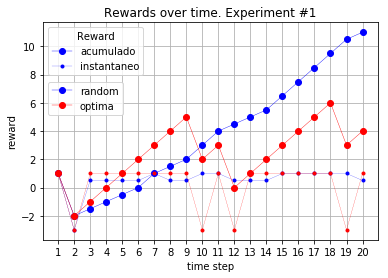

In [28]:
plotRewardFromData([data1RandPol, data1], ["random", "optima"], "Experiment #1")

In [29]:
# Generating data for experiment #2
exp2.reset()
data2RandPol = getExperimentData(exp2, 20)
exp2.reset()
data2 = getExperimentData(exp2, 20, policy2)

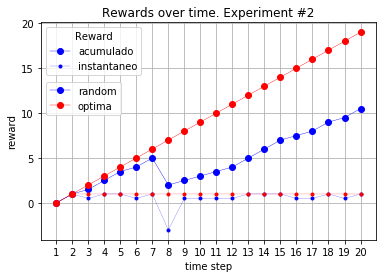

In [30]:
plotRewardFromData([data2RandPol, data2], ["random", "optima"], "Experiment #2")

In [31]:
# Generating data for experiment #3
exp3.reset()
data3RandPol = getExperimentData(exp3, 20)
exp3.reset()
data3 = getExperimentData(exp3, 20, policy3)

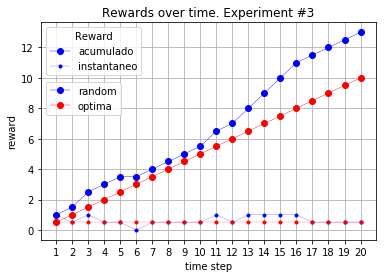

In [32]:
plotRewardFromData([data3RandPol, data3], ["random", "optima"], "Experiment #3")

In [33]:
# Generating data for experiment #3
exp4.reset()
data4RandPol = getExperimentData(exp4, 20)
exp4.reset()
data4 = getExperimentData(exp4, 20, policy4)

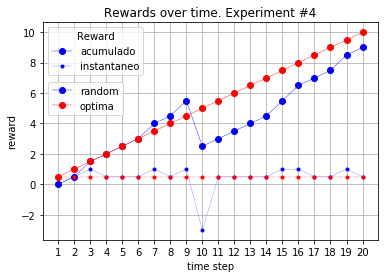

In [34]:
plotRewardFromData([data4RandPol, data4], ["random", "optima"], "Experiment #4")

In [35]:
# Generating data for experiment #5
exp5.reset()
data5RandPol = getExperimentData(exp5, 20)
exp5.reset()
data5 = getExperimentData(exp5, 20, policy5)

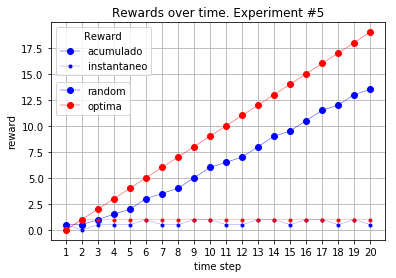

In [36]:
plotRewardFromData([data5RandPol, data5], ["random", "optima"], "Experiment #5")

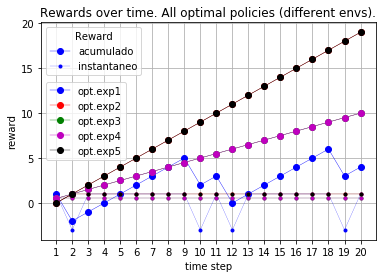

In [37]:
plotRewardFromData([data1, data2, data3, data4, data5],
                   ["opt.exp1", "opt.exp2", "opt.exp3", "opt.exp4", "opt.exp5"],
                  "All optimal policies (different envs).")

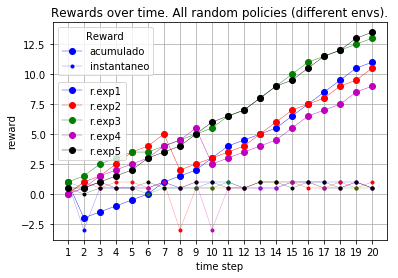

In [38]:
plotRewardFromData([data1RandPol, data2RandPol, data3RandPol, data4RandPol, data5RandPol],
                   ["r.exp1"  , "r.exp2"  , "r.exp3"  , "r.exp4"  , "r.exp5"],
                  "All random policies (different envs).")

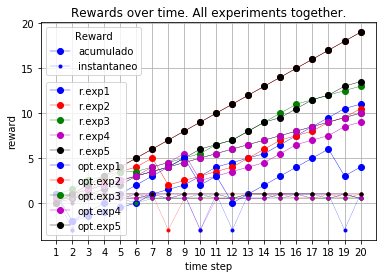

In [39]:
plotRewardFromData([data1RandPol, data2RandPol, data3RandPol, data4RandPol, data5RandPol,
                    data1, data2, data3, data4, data5],
                   ["r.exp1"  , "r.exp2"  , "r.exp3"  , "r.exp4"  , "r.exp5",
                    "opt.exp1", "opt.exp2", "opt.exp3", "opt.exp4", "opt.exp5"],
                  "All experiments together.")

In [45]:
# https://gym.openai.com/envs/FrozenLake8x8-v0/
#EnvSpec(FrozenLake-v0), EnvSpec(FrozenLake8x8-v0)

In [44]:
import gym

In [62]:
env = gym.make('FrozenLake8x8-v0')

In [65]:
print(env.reset())

0


In [74]:
for x in range(8):
    for y in range(8):
        print(x*8+y, end=" ", flush=True)
    print("")
    

0 1 2 3 4 5 6 7 
8 9 10 11 12 13 14 15 
16 17 18 19 20 21 22 23 
24 25 26 27 28 29 30 31 
32 33 34 35 36 37 38 39 
40 41 42 43 44 45 46 47 
48 49 50 51 52 53 54 55 
56 57 58 59 60 61 62 63 


In [61]:
def testValueIteration():
    env = gym.make('FrozenLake8x8-v0')
    env.reset()
    print("Value function optima:")
    print(valueIteration(env=env, theta=0.000001, gamma=0.99, verbose=True))
testValueIteration()

Value function optima:
epoch	value V
1 : [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.33333333 0.         0.         0.         0.
 0.         0.         0.33333333 0.        ]
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.   

In [75]:
# Experimento #1
# Policy optima: Buscar siempre
exp1 = gym.make('FrozenLake8x8-v0')
print("Value from Value Iteration:")
print(valueIteration(env=exp1, gamma=gamma, verbose=False), "\n")
policy1, V1 = testPolicyImprovementWithRandomPolicy(env=exp1, gamma=gamma)
print("Optimal policy: \n", policy1, "\nValue from optimal policy: \n", V1)

Value from Value Iteration:
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.33333333 0.         0.         0.         0.
 0.         0.         0.33333333 0.        ] 

Using Policy Improvement
Random policy to improve:
[[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.

ValueError: a and p must have same size